# Compile Tuned models

We grab the tuned models (performed using the Levenberg Marquadt algorithm on the Sciama HPC).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import json
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from gzbuilder_analysis.parsing import unmake_json
from gzbuilder_analysis.fitting import Model, loss
import lib.galaxy_utilities as gu

Could not find some files, some functions may not work


In [3]:
def make_model(subject_id, m):
    psf = gu.get_psf(subject_id)
    diff_data = gu.get_diff_data(subject_id)
    pixel_mask = 1 - np.array(diff_data['mask'])[::-1]
    galaxy_data = np.array(diff_data['imageData'])[::-1]
    return Model(m, galaxy_data, psf=psf, pixel_mask=pixel_mask)

In [4]:
AGG_MODEL_PATH = 'fitted_agg_models'
BI_MODEL_PATH = 'fitted_bi_models'

available_agg_models = [
  i for i in os.listdir(AGG_MODEL_PATH)
  if re.match(r'[0-9]+\.json', i)
]
available_bi_models = [
  i for i in os.listdir(BI_MODEL_PATH)
  if re.match(r'[0-9]+\.json', i)
]

In [5]:
agg_models = pd.Series([])
agg_losses = pd.Series([]).rename('agg_loss')
with tqdm(available_agg_models, desc='Aggregate') as bar:
  for f in bar:
    subject_id = int(f.split('.')[0])
    with open(os.path.join(AGG_MODEL_PATH, f)) as f_in:
      model = unmake_json(json.load(f_in))
    model_obj = make_model(subject_id, model)
    agg_models[subject_id] = model_obj

    r = model_obj.render()
    agg_losses[subject_id] = loss(
      r,
      model_obj.data,
      pixel_mask=model_obj.pixel_mask
    )

Aggregate: 100%|██████████| 262/262 [02:51<00:00,  2.02it/s]


In [6]:
bi_models = pd.Series([])
bi_losses = pd.Series([]).rename('bi_loss')
with tqdm(available_bi_models, desc='Best Individual') as bar:
  for f in bar:
    subject_id = int(f.split('.')[0])
    with open(os.path.join(BI_MODEL_PATH, f)) as f_in:
      model = unmake_json(json.load(f_in))
    model_obj = make_model(subject_id, model)
    bi_models[subject_id] = model_obj
    r = model_obj.render(model_obj._model)
    bi_losses[subject_id] = loss(
      r,
      model_obj.data,
      pixel_mask=model_obj.pixel_mask
    )

Best Individual: 100%|██████████| 256/256 [03:21<00:00,  2.31it/s]


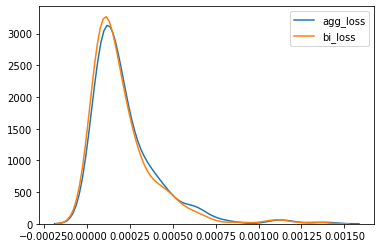

In [7]:
_, axs = plt.subplots(ncols=2, figsize=(12, 4), dpi=100)
plt.sca(axs[0])
sns.kdeplot(agg_losses)
sns.kdeplot(bi_losses)

plt.sca(axs[1])
diff = agg_losses - bi_losses
sns.kdeplot(diff.dropna(), shade=True)
plt.xlabel('Agg loss - BI loss (>0 if BI better)')
l = plt.ylim()[1]
plt.vlines(diff.median(), -10, l, alpha=0.2)
plt.ylim(0, l);

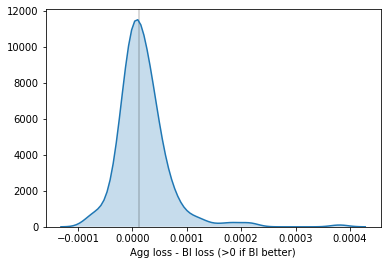

In [8]:
diff = agg_losses - bi_losses
sns.kdeplot(diff.dropna(), shade=True)
plt.xlabel('Agg loss - BI loss (>0 if BI better)')
l = plt.ylim()[1]
plt.vlines(diff.median(), -10, l, alpha=0.2)
plt.ylim(0, l);

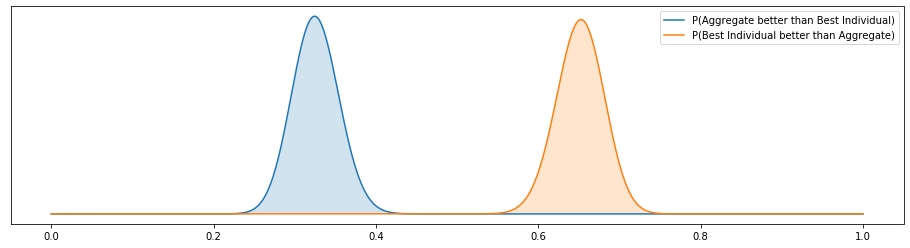

In [9]:
x = np.linspace(0, 1, 1000)
p_agg_better = st.beta.pdf(x, 1 + (diff < 0).sum(), 1 + len(diff) - (diff < 0).sum())
p_bi_better = st.beta.pdf(x, 1 + (diff > 0).sum(), 1 + len(diff) - (diff > 0).sum())
plt.figure(figsize=(16, 4))
plt.plot(x, p_agg_better, label='P(Aggregate better than Best Individual)')
plt.fill_between(x, 0, p_agg_better, alpha=0.2)
plt.plot(x, p_bi_better, label='P(Best Individual better than Aggregate)')
plt.fill_between(x, 0, p_bi_better, alpha=0.2)
plt.legend()
plt.yticks([]);

What do the models look like where the differences between aggregate and models are largest?

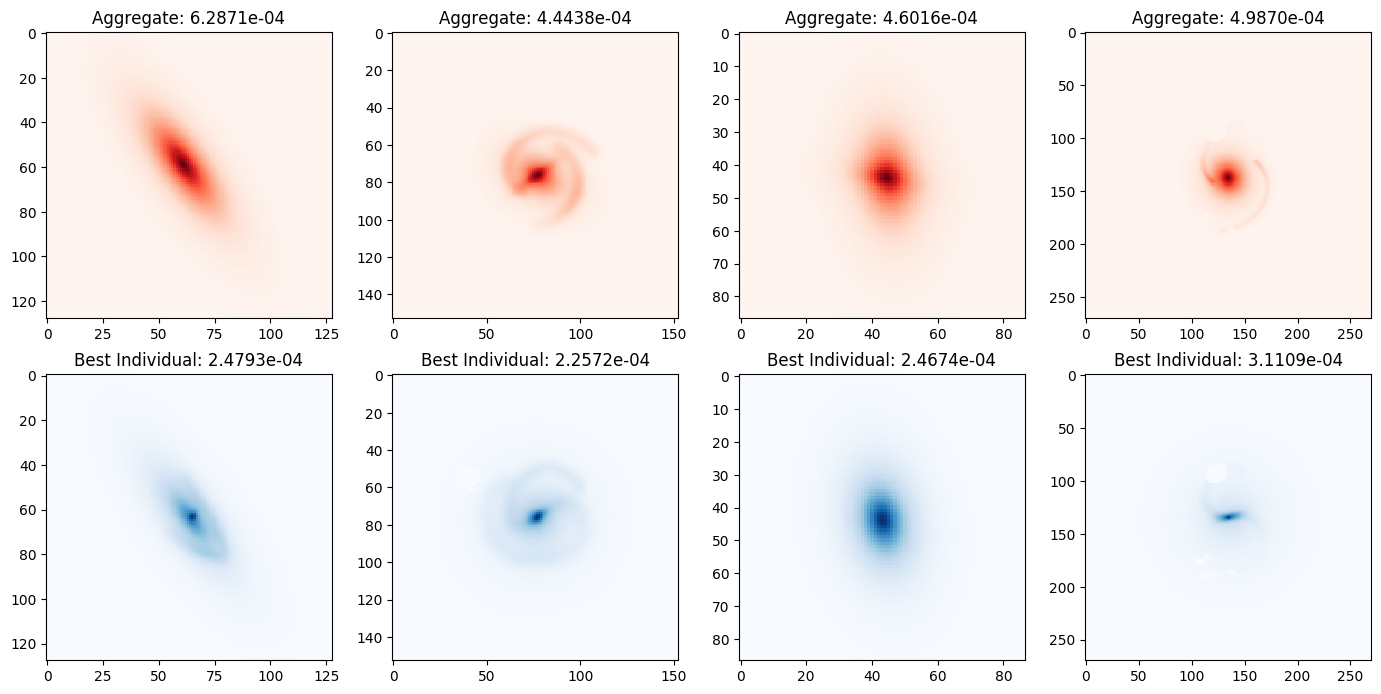

In [10]:
_, ax = plt.subplots(nrows=2, ncols=4, figsize=(14, 7), dpi=100)
for i, idx in enumerate(diff.abs().sort_values(ascending=False).index[:4]):
  agg_better = agg_losses.loc[idx] < bi_losses.loc[idx]
  a = agg_models.loc[idx]
  b = bi_models.loc[idx]
  ax[0][i].imshow(a.render() * a.pixel_mask ,
                  cmap=('Blues' if agg_better else 'Reds'))
  ax[0][i].set_title('Aggregate: {:.4e}'.format(agg_losses.loc[idx]))
  ax[1][i].imshow(b.render() * b.pixel_mask,
                  cmap=('Reds' if agg_better else 'Blues'))
  ax[1][i].set_title('Best Individual: {:.4e}'.format(bi_losses.loc[idx]))
plt.tight_layout()

What about when the models are the most similar?

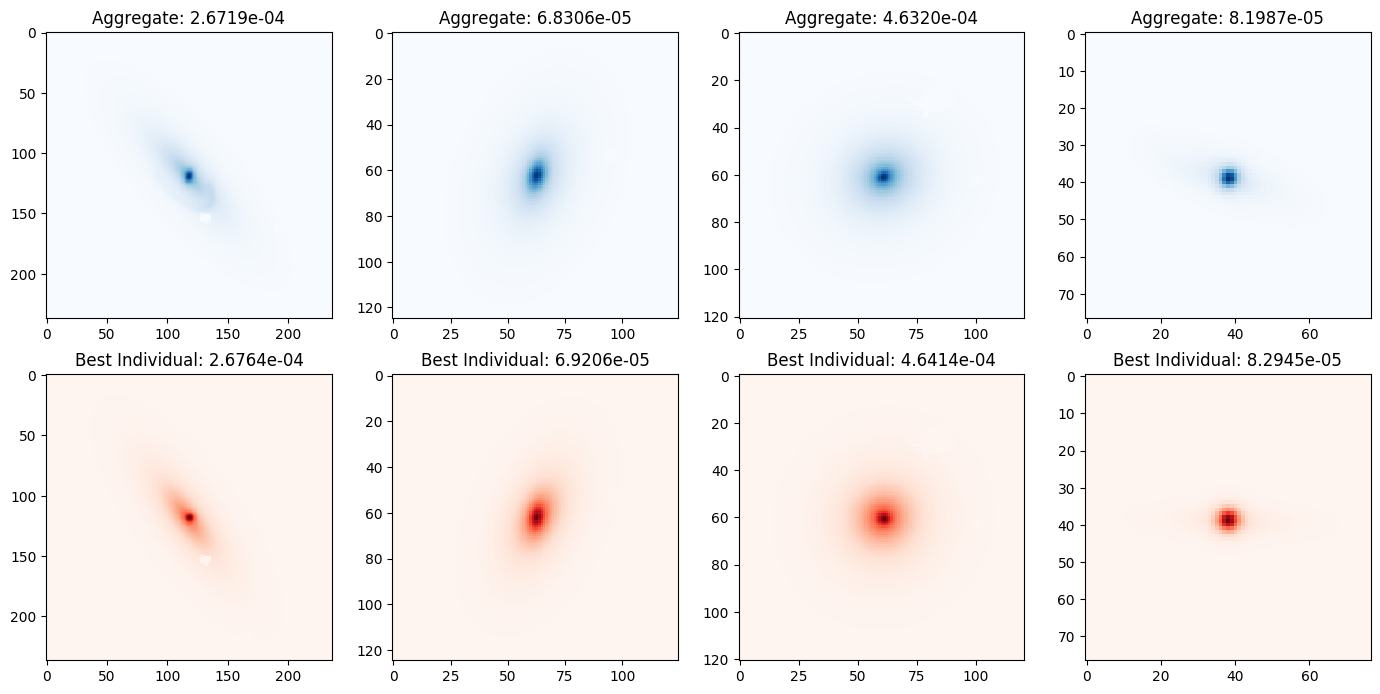

In [11]:
_, ax = plt.subplots(nrows=2, ncols=4, figsize=(14, 7), dpi=100)
for i, idx in enumerate(diff.abs().sort_values(ascending=True).index[:4]):
  agg_better = agg_losses.loc[idx] < bi_losses.loc[idx]
  a = agg_models.loc[idx]
  b = bi_models.loc[idx]
  ax[0][i].imshow(a.render() * a.pixel_mask ,
                  cmap=('Blues' if agg_better else 'Reds'))
  ax[0][i].set_title('Aggregate: {:.4e}'.format(agg_losses.loc[idx]))
  ax[1][i].imshow(b.render() * b.pixel_mask,
                  cmap=('Reds' if agg_better else 'Blues'))
  ax[1][i].set_title('Best Individual: {:.4e}'.format(bi_losses.loc[idx]))
plt.tight_layout()

In [12]:
print('Saving fitted models')
fitted_models = pd.DataFrame([], columns=('agg', 'bi', 'agg_loss', 'bi_loss'))
for i in bi_models.index:
  fitted_models.loc[i] = dict(
    agg=agg_models.loc[i]._model,
    bi=bi_models.loc[i]._model,
    agg_loss=agg_losses.loc[i],
    bi_loss=bi_losses.loc[i],
  )
fitted_models.to_pickle('lib/fitted_models.pickle')

Saving fitted models
